# Problem Tanımı
### İş Bankası mobil uygulamasını kullanan kullanıcıların en çok ihtiyaç duyduğu ve en çok kullandığı menüleri tahminleyerek kullanıcı özelinde arayüz oluşturabilmek.

# Veriye Genel Bakış

In [1]:
 #!pip install optuna
import optuna
import seaborn as sns
import numpy as np 
import pandas as pd
import pandas as pd
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt



from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.metrics import  jaccard_score,confusion_matrix, multilabel_confusion_matrix, classification_report,recall_score,f1_score

pd.set_option('display.max_columns', None)

## çözümün özeti 

1. Eğitim verisetinde null değer  olmadığını görünce ilk olarak çok fazla kategoriye sahip carrier ve devicebrand kolonundaki az olan değerleri other kategorisi altında toparladım.

2. target kolonunu binary formata çevirdim ve kategorik değerlere one-hot encoding uyguladım.


3. modelde 3 kfold , MultiOutputClassifier,voting classifierı birlikte kullandım. voting classifier da 3 tane model vardı ligtgbm,logistic_regression ve catboost, 3ü birlikte çok daha iyi sonuçlar veriyordu. ayrıca lightgbm ve logisticregression diğer modellere göre çok daha hızlıydı.  


4. model değerlerndirmesi ve tahmin.

In [2]:
train = pd.read_parquet("/kaggle/input/turkiye-is-bankasi-ml-challenge-5/train_final.parquet")
test = pd.read_parquet("/kaggle/input/turkiye-is-bankasi-ml-challenge-5/test_final.parquet")
submission = pd.read_parquet("/kaggle/input/turkiye-is-bankasi-ml-challenge-5/submission_sample_final.parquet")

In [3]:
#  eksik veri  veya yanlış formatta değişken bulunmuyor
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94049 entries, 0 to 94048
Data columns (total 58 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           94049 non-null  object 
 1   month        94049 non-null  int64  
 2   n_seconds_1  94049 non-null  float64
 3   n_seconds_2  94049 non-null  float64
 4   n_seconds_3  94049 non-null  float64
 5   carrier      94049 non-null  object 
 6   devicebrand  94049 non-null  object 
 7   feature_0    94049 non-null  float64
 8   feature_1    94049 non-null  float64
 9   feature_2    94049 non-null  float64
 10  feature_3    94049 non-null  float64
 11  feature_4    94049 non-null  float64
 12  feature_5    94049 non-null  float64
 13  feature_6    94049 non-null  float64
 14  feature_7    94049 non-null  float64
 15  feature_8    94049 non-null  float64
 16  feature_9    94049 non-null  float64
 17  feature_10   94049 non-null  float64
 18  feature_11   94049 non-null  float64
 19  feat

In [4]:
for_num = train.iloc[:,[1,5,6,57]].columns
num_features = [col for col in train.columns if col not in for_num]
cat_features = train.iloc[:,[0,1,5,6,57]].columns


to_get_variables = train.iloc[:,[5,6,57]].columns
to_get_means = [col for col in train.columns if col not in to_get_variables]

In [5]:
print(train.target.value_counts())

print("\n") 

print(train.carrier.value_counts())

print("\n") 

print(train.devicebrand.value_counts())

print("\n") 

print(train.id.value_counts())

# çok fazla gereksiz kategorik veri var ve bazı  kullanıcıların briden fazla trainde yer alıyor bunları gruplandırarak yeni özellikler oluşturabiliriz.

target
menu6, menu2, menu8    13583
menu6, menu2, menu4    12827
menu6, menu2, menu1     8891
menu6, menu2, menu5     4861
menu2, menu4, menu5     3861
                       ...  
menu3, menu4, menu7        5
menu3, menu7, menu1        4
menu3, menu1, menu7        3
menu3, menu8, menu7        3
menu3, menu7, menu8        2
Name: count, Length: 112, dtype: int64


carrier
TURKCELL        39043
VODAFONE TR     25583
TURK TELEKOM    22091
BIMCELL          1108
Unknown           684
                ...  
MOBILIS             1
AF AWCC             1
SMART               1
REGLO MOBILE        1
BELALIM             1
Name: count, Length: 556, dtype: int64


devicebrand
Apple         33238
samsung       31971
Redmi          7709
HUAWEI         6595
xiaomi         5300
              ...  
Cat               1
HOMETECH          1
WIKO              1
Gigaset           1
blackshark        1
Name: count, Length: 64, dtype: int64


id
60f93207a330776bbe5bd4fb2    3
1e8e75ceed6b16660d5531b5c    3
793a9

# Data Cleaning 

In [6]:
# bazı operatörler farklı adda yer alsada büyük operatörlerin altında yer alıyor o yüzden onları diğer ait olduğu operatörlere çevirdim. 


def fordummies(train):
    train.loc[train.carrier=="PTTCELL", 'carrier'] = "TURK TELEKOM"
    train.loc[train.carrier=="HAYATEVESIGAR", 'carrier'] = "TURK TELEKOM"
    train.loc[train.carrier=="TEKNOSACELL", 'carrier'] = "TURK TELEKOM"
    train.loc[train.carrier=="BIMCELL", 'carrier'] = "TURK TELEKOM"
    train.loc[train.carrier=="FENERCELL", 'carrier'] = "TURK TELEKOM"
    train.loc[train.carrier=="VODAFONE", 'carrier'] = "VODAFONE TR"
    train.loc[train.carrier=="VODAFONE.DE", 'carrier'] = "VODAFONE TR"
    train.loc[train.carrier=="KKTCELL", 'carrier'] = "TURKCELL"
    train.loc[train.carrier=="LIFECELL TR", 'carrier'] = "TURKCELL"
    train.loc[train.carrier=="TR TURKCELL", 'carrier'] = "TURKCELL"



    #  en çok kullanılan cihaz markaları
    train.loc[~train['carrier'].isin(['TURKCELL', 'VODAFONE TR', 'TURK TELEKOM']), 'carrier'] = 'other'
    train.loc[~train['devicebrand'].isin(['Apple', 'samsung', 'Redmi', 'HUAWEI', 'xiaomi', 'OPPO', 'POCO', 'GM','realme']), 'devicebrand'] = 'other'
    
    
    
    dummies = pd.get_dummies(train[['carrier','devicebrand']],dtype=(int))
    train = pd.concat([train, dummies],axis=1)
    
    return train 




train = fordummies(train)
test = fordummies(test)



# encoder id kolonu için
idencoder = LabelEncoder()
train['id'] =  idencoder.fit_transform(np.concatenate([train.id,test.id],axis=0))[:94049]
test['id'] =  idencoder.transform(test.id)

In [7]:
# targetı binary formata çevirme

target = train['target']
target = target.str.split(', ')
mlb = MultiLabelBinarizer()
encoded_target = mlb.fit_transform(target)
encoded_target_df = pd.DataFrame(encoded_target, columns=mlb.classes_)
train = pd.concat([encoded_target_df,train],axis=1)

# veri görselleştirme

Text(0.5, 1.0, 'Target Dağılımı')

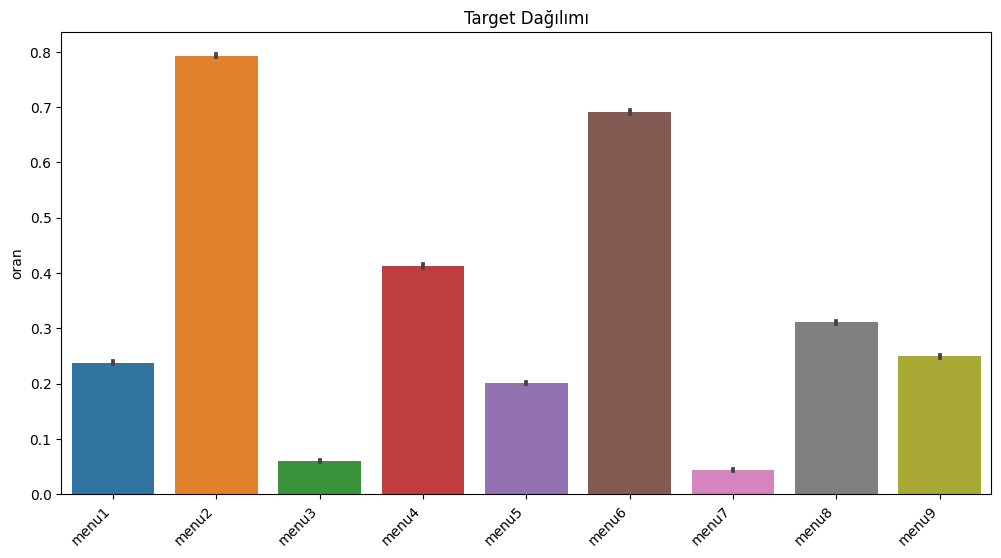

In [8]:
plt.figure(figsize=(12, 6))

sns.barplot(data=train.iloc[:,:9] )
plt.xticks(rotation=45, horizontalalignment="right")
plt.ylabel("oran")
plt.title("Target Dağılımı")

# menü2 kullanıcıların yüzde 80ninde ilk 3 menüde yer alıyor 

### Değişkenlerin dağılımı

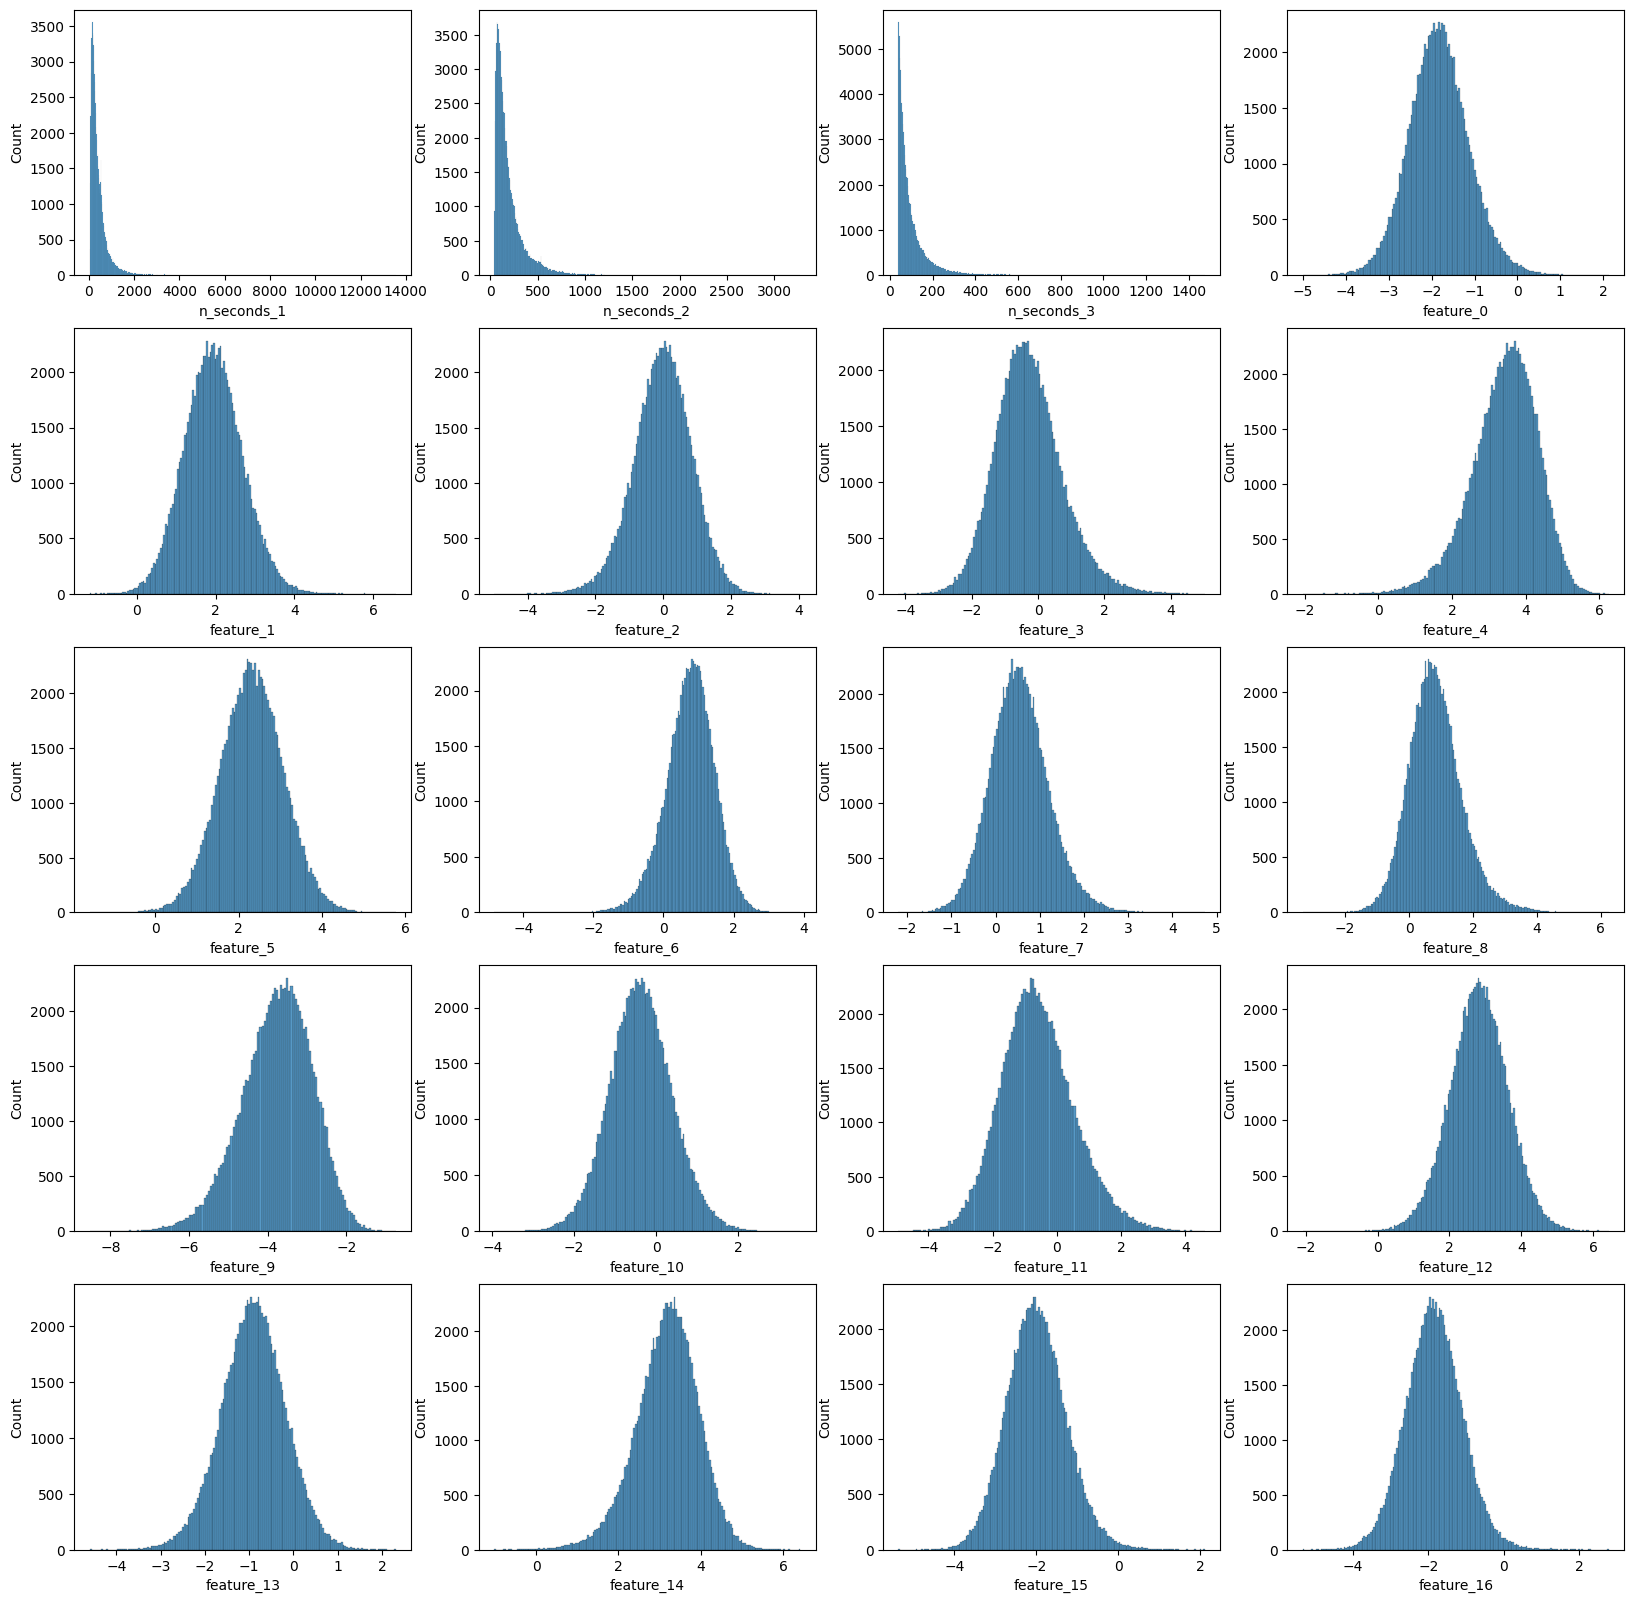

In [9]:
df = train[num_features].iloc[:,1:]
plt.figure(figsize=(20,20))
num_subplots = min(len(df), 20) 
for i in range(1, num_subplots + 1):
    plt.subplot(5, 4, i)
    sns.histplot(x=df[df.columns[i-1 ]])

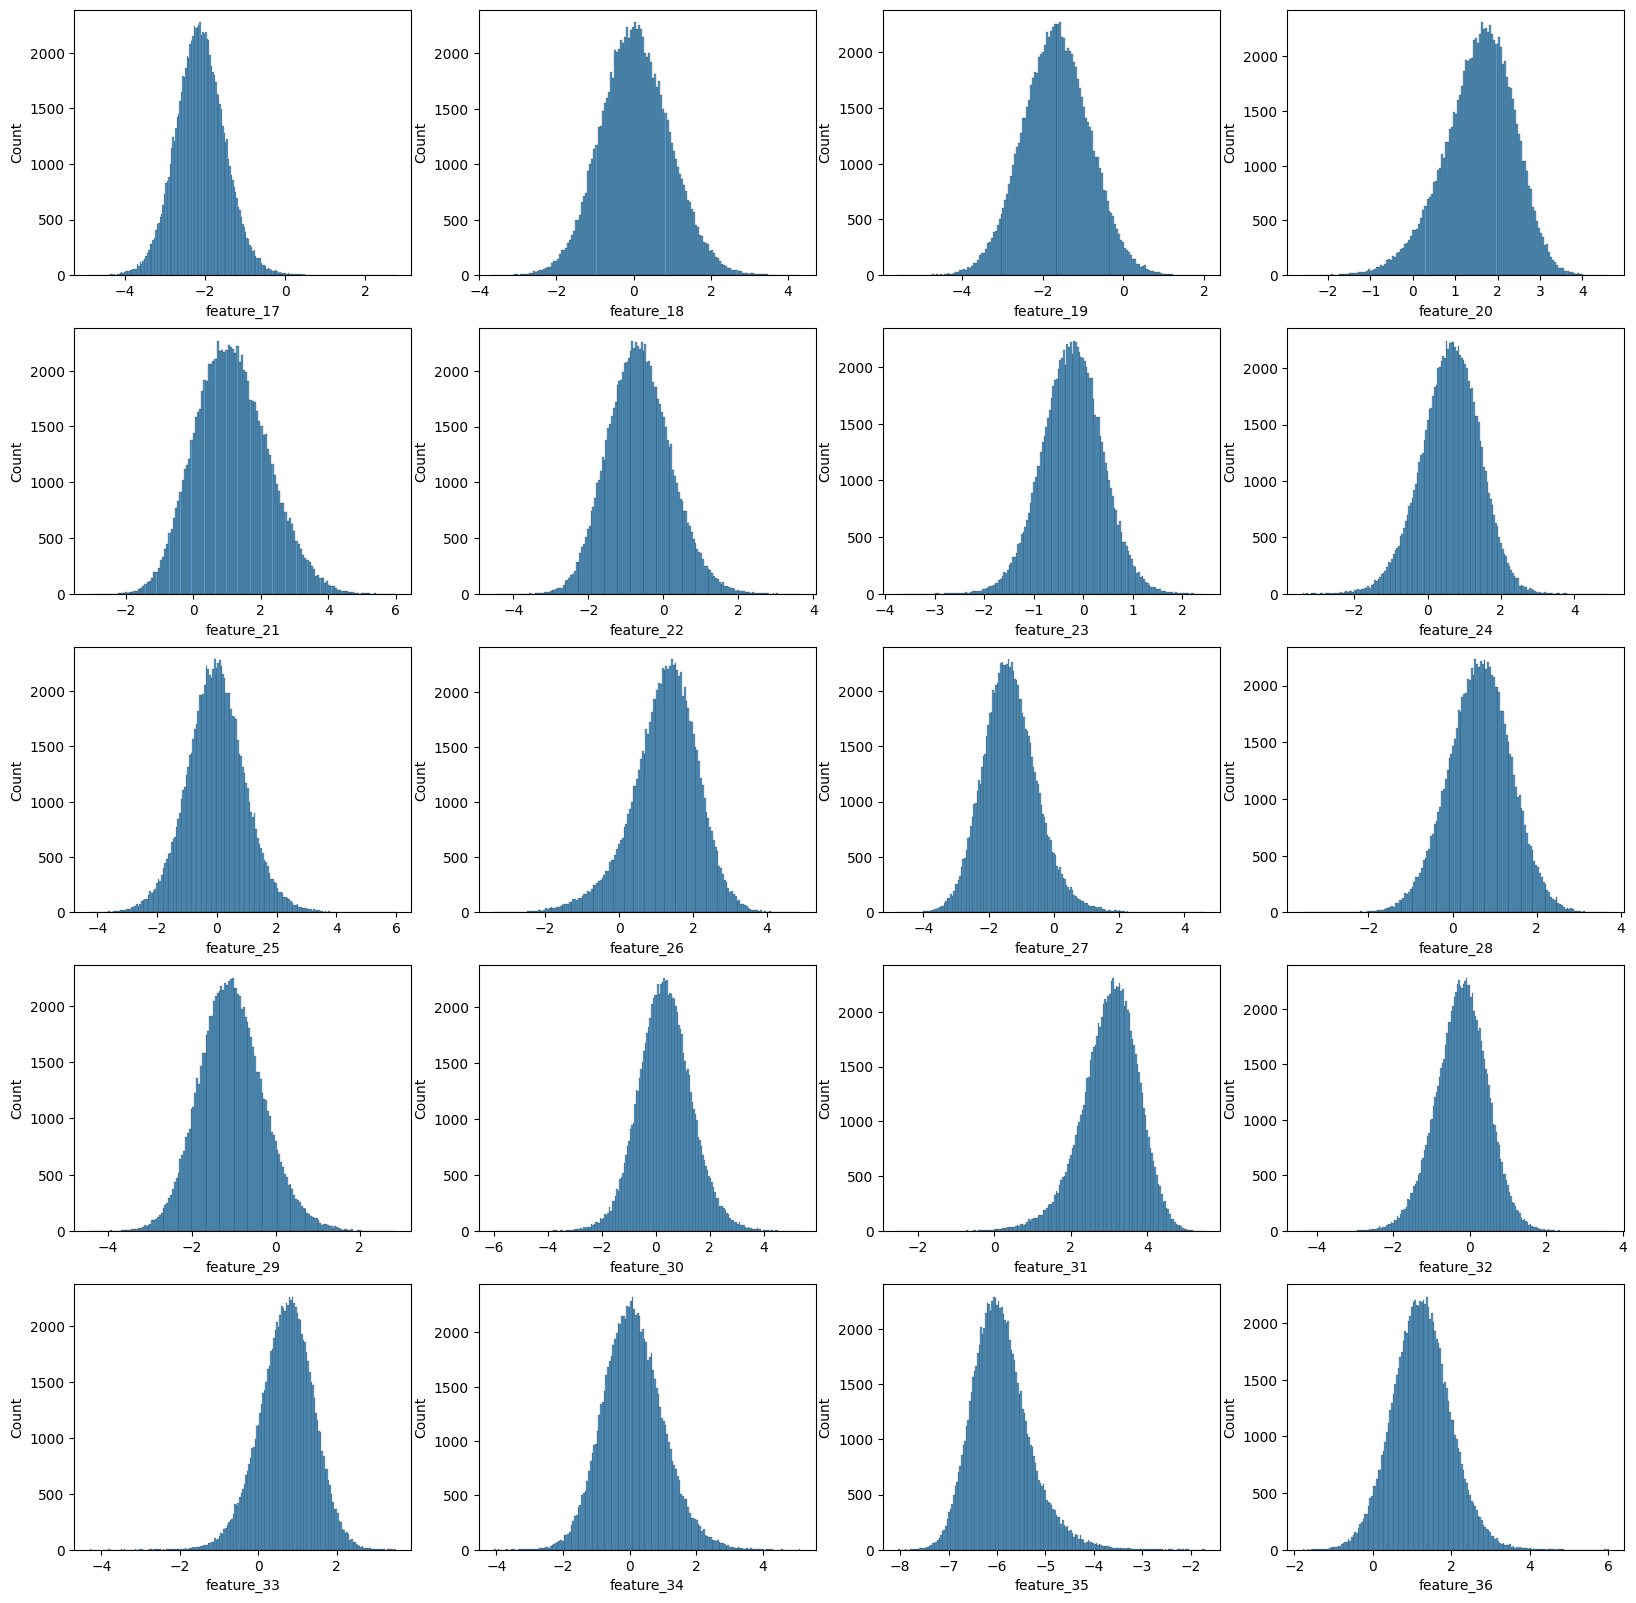

In [10]:
plt.figure(figsize=(20, 20))
for i in range(1, min(21, len(df))):
    plt.subplot(5, 4, i)
    sns.histplot(x=df[df.columns[19 + i]])

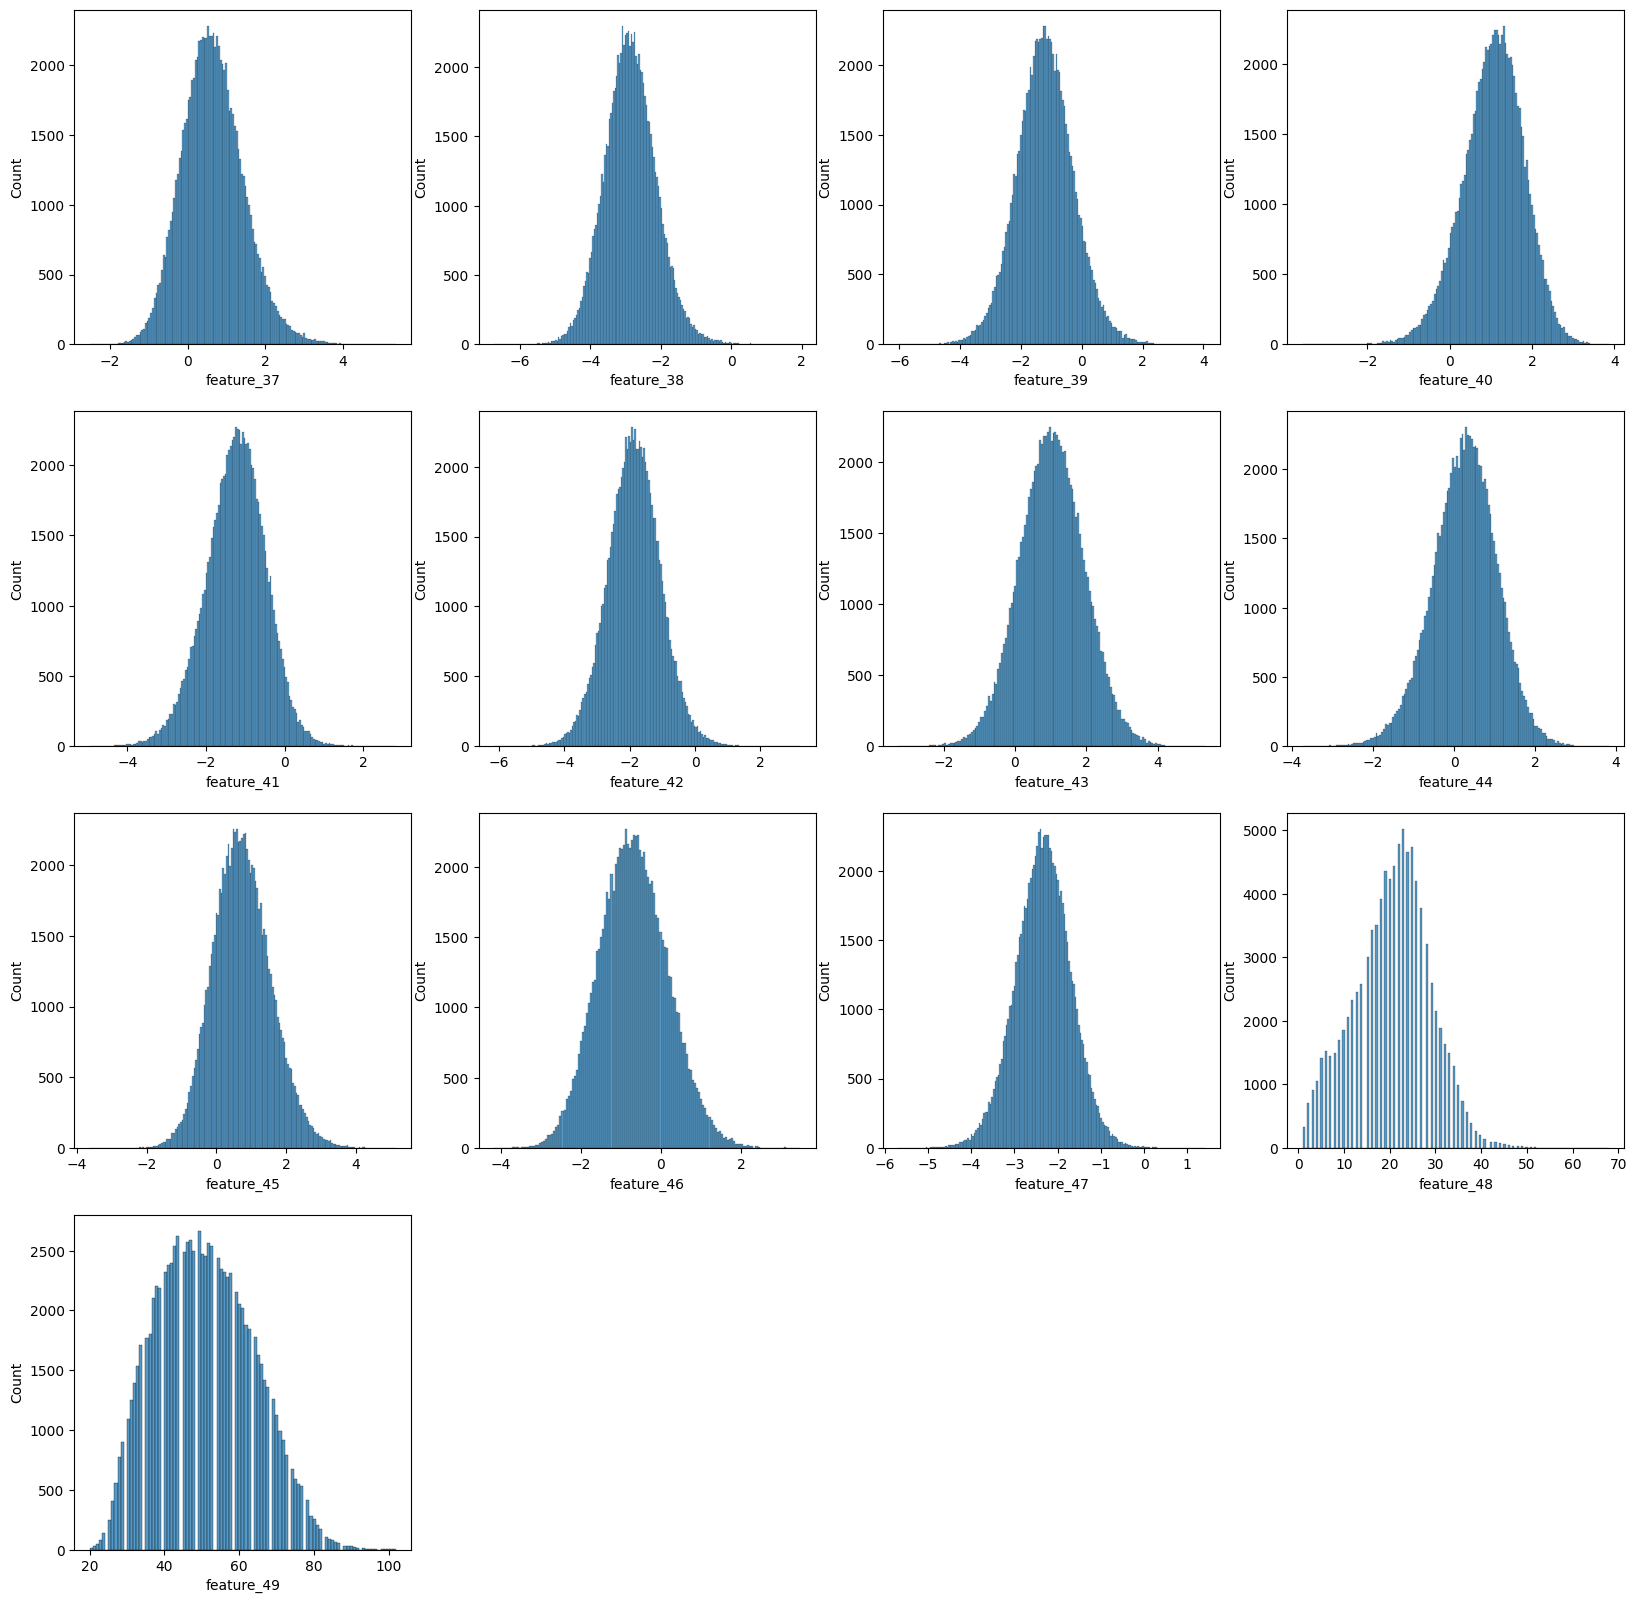

In [11]:
plt.figure(figsize=(20, 20))
for i in range(1, min(40, 52)):
    column_index = 39 + i
    if column_index < len(df.columns):
        plt.subplot(4, 4, i)
        sns.histplot(x=df[df.columns[column_index]])

Text(0.5, 1.0, 'Operatörlerin dağılımı')

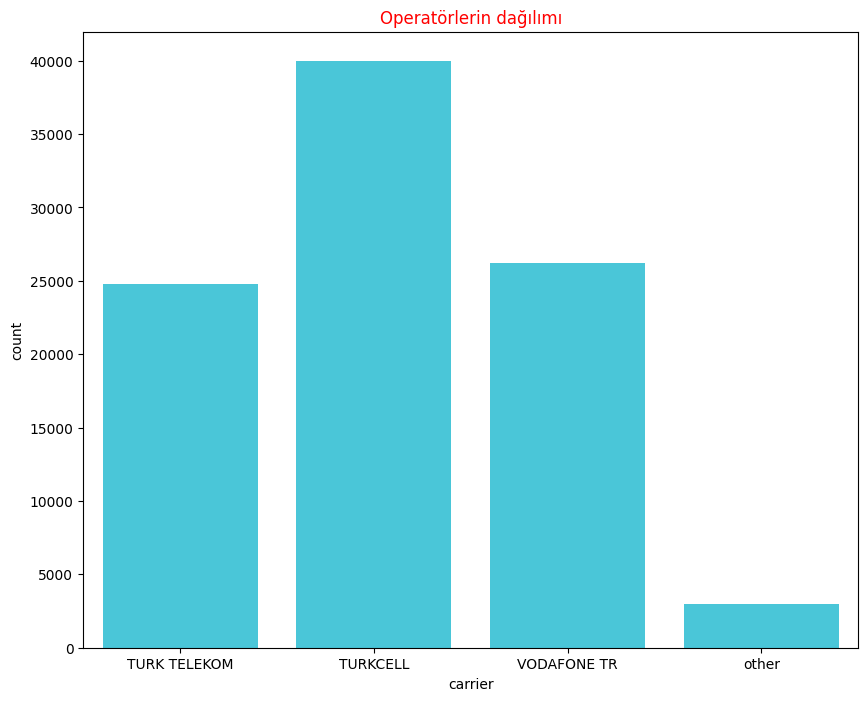

In [12]:
custom_color = (50/255, 216/255, 230/245) 
plt.figure(figsize=(10,8))
df = train.groupby(by='carrier').count()['menu1'].reset_index() 
df.columns =['carrier','count'] 
sns.barplot(df, y='count', x='carrier',color=custom_color)
plt.title('Operatörlerin dağılımı',color='red')

Text(0.5, 1.0, 'Uygulamaya girilen cihazların dağılımı')

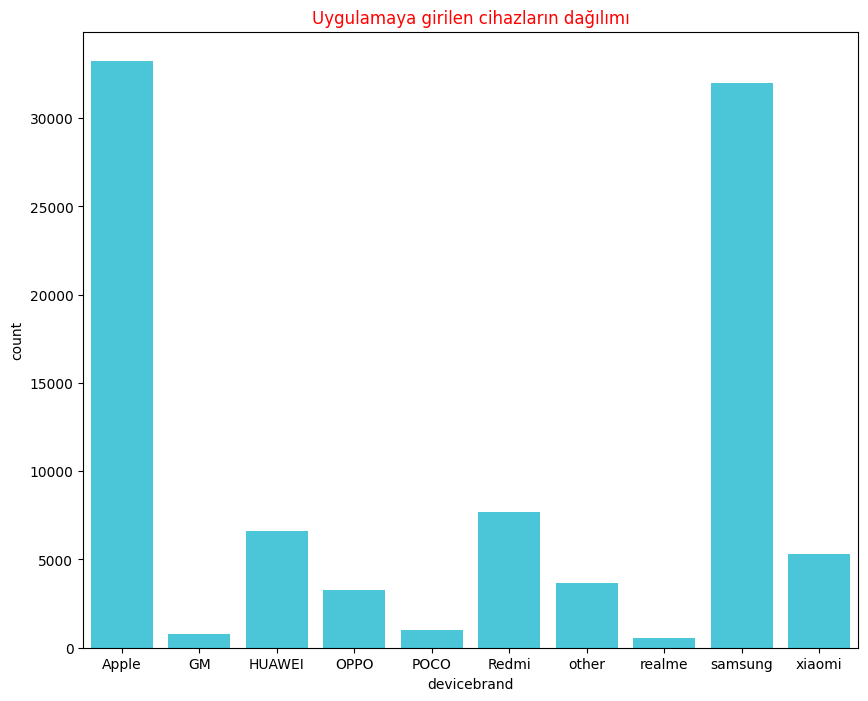

In [13]:
custom_color = (50/255, 216/255, 230/245) 
plt.figure(figsize=(10,8))
df = train.groupby(by='devicebrand').count()['menu1'].reset_index() 
df.columns =['devicebrand','count'] 
sns.barplot(df, y='count', x='devicebrand',color=custom_color)
plt.title('Uygulamaya girilen cihazların dağılımı',color='red')

## Yeni özellikler

In [14]:
getmeans = (pd.concat([train,test],axis=0))
getmeans_means = getmeans[to_get_means].groupby('id').mean().reset_index()
train = train.merge(getmeans_means, on='id',how='left', suffixes=('_train', '_mean'))
test = test.merge(getmeans_means, on='id',how='left', suffixes=('_train', '_mean'))

In [15]:
# modelin tahmin ettiği probalardan en iyi 3 ünü seçmek için fonksiyon
def topprobas(pro):
    result = np.zeros_like(pro) 
    for i in range(len(pro)):
        indices = np.argpartition(pro[i], -3)[-3:]  
        result[i, indices] = 1  
    return result

## Params

In [16]:

### optuna ile bulunan parametreler

lgbbests  = {'learning_rate': 0.1,
 'num_leaves': 47,
 'n_estimators': 96,
 'min_child_samples': 298,
 'reg_alpha': 0.0023206893898312765,
 'reg_lambda': 0.05066027938622197,
                }


logbests = {'C': 0.1, 'max_iter': 300, 'intercept_scaling': 150 , 'solver': 'liblinear', 'penalty':'l1' }


catbests = {
   'learning_rate': 0.044,
   'depth':7,
   'iterations': 1400,
    'silent': True
 
}

# Model

In [17]:
train.columns[:100]

Index(['menu1', 'menu2', 'menu3', 'menu4', 'menu5', 'menu6', 'menu7', 'menu8',
       'menu9', 'id', 'month_train', 'n_seconds_1_train', 'n_seconds_2_train',
       'n_seconds_3_train', 'carrier', 'devicebrand', 'feature_0_train',
       'feature_1_train', 'feature_2_train', 'feature_3_train',
       'feature_4_train', 'feature_5_train', 'feature_6_train',
       'feature_7_train', 'feature_8_train', 'feature_9_train',
       'feature_10_train', 'feature_11_train', 'feature_12_train',
       'feature_13_train', 'feature_14_train', 'feature_15_train',
       'feature_16_train', 'feature_17_train', 'feature_18_train',
       'feature_19_train', 'feature_20_train', 'feature_21_train',
       'feature_22_train', 'feature_23_train', 'feature_24_train',
       'feature_25_train', 'feature_26_train', 'feature_27_train',
       'feature_28_train', 'feature_29_train', 'feature_30_train',
       'feature_31_train', 'feature_32_train', 'feature_33_train',
       'feature_34_train', 'feature_35_tr

In [18]:
"""-------------------------------------------------------"""

model_train = train.copy()
scores = []
proba_scores = []

tests = []
preds = []
probalar = []


tscv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_idx, val_idx in tscv.split(model_train):
    train_data = model_train.iloc[train_idx]
    test_data = model_train.iloc[val_idx]

    X_train, y_train = train_data, model_train.iloc[train_idx, :9]
    X_test, y_test = test_data, model_train.iloc[val_idx, :9]

    features = ['id', 'month_train', 'n_seconds_1_train', 'n_seconds_2_train',
       'n_seconds_3_train', 'feature_0_train',
       'feature_1_train', 'feature_2_train', 'feature_3_train',
       'feature_4_train', 'feature_5_train', 'feature_6_train',
       'feature_7_train', 'feature_8_train', 'feature_9_train',
       'feature_10_train', 'feature_11_train', 'feature_12_train',
       'feature_13_train', 'feature_14_train', 'feature_15_train',
       'feature_16_train', 'feature_17_train', 'feature_18_train',
       'feature_19_train', 'feature_20_train', 'feature_21_train',
       'feature_22_train', 'feature_23_train', 'feature_24_train',
       'feature_25_train', 'feature_26_train', 'feature_27_train',
       'feature_28_train', 'feature_29_train', 'feature_30_train',
       'feature_31_train', 'feature_32_train', 'feature_33_train',
       'feature_34_train', 'feature_35_train', 'feature_36_train',
       'feature_37_train', 'feature_38_train', 'feature_39_train',
       'feature_40_train', 'feature_41_train', 'feature_42_train',
       'feature_43_train', 'feature_44_train', 'feature_45_train',
       'feature_46_train', 'feature_47_train', 'feature_48_train',
       'feature_49_train',  'carrier_TURK TELEKOM',
       'carrier_TURKCELL', 'carrier_VODAFONE TR',
       'carrier_other', 'devicebrand_Apple',
        'devicebrand_HUAWEI',
       'devicebrand_OPPO', 
       'devicebrand_Redmi', 'devicebrand_other',
        'devicebrand_samsung',
       'devicebrand_xiaomi',  'n_seconds_1_mean',
       'n_seconds_2_mean', 'n_seconds_3_mean', 'feature_0_mean',
       'feature_1_mean', 'feature_2_mean', 'feature_3_mean', 'feature_4_mean',
       'feature_5_mean', 'feature_6_mean', 'feature_7_mean', 'feature_8_mean',
       'feature_9_mean', 'feature_10_mean', 'feature_11_mean',
       'feature_12_mean', 'feature_13_mean', 'feature_14_mean',
        'feature_15_mean', 'feature_16_mean', 'feature_17_mean',
       'feature_18_mean', 'feature_19_mean', 'feature_20_mean',
       'feature_21_mean', 'feature_22_mean', 'feature_23_mean',
       'feature_24_mean', 'feature_25_mean', 'feature_26_mean',
       'feature_27_mean', 'feature_28_mean', 'feature_29_mean',
       'feature_30_mean', 'feature_31_mean', 'feature_32_mean',
       'feature_33_mean', 'feature_34_mean', 'feature_35_mean',
       'feature_36_mean', 'feature_37_mean', 'feature_38_mean',
       'feature_39_mean', 'feature_40_mean', 'feature_41_mean',
       'feature_42_mean', 'feature_43_mean', 'feature_44_mean',
       'feature_45_mean', 'feature_46_mean', 'feature_47_mean',
       'feature_48_mean', 'feature_49_mean']

 
    
    
    
    
    classifier1 = lgb.LGBMClassifier(**lgbbests)
    classifier2 = LogisticRegression(**logbests) 
    classifier3 = CatBoostClassifier(**catbests)
 
   
    
    voting_classifier = VotingClassifier(estimators=[
        

                                                 ('lgbm', classifier1),
                                                 ('log', classifier2),
                                                 ('catboost', classifier3),
                                   
                                                                          ], voting='soft',verbose=True) 

    
    
    
    
    ml = MultiOutputClassifier(voting_classifier)
    ml.fit(X_train[features] , y_train  )
    predicted_ = ml.predict(X_test[features])
    proba = ml.predict_proba(X_test[features])
    preds.append(predicted_)
    tests.append(y_test)

    
    
    
    probalar.append(np.array(proba)[:, :, 1].T)
    probas = proba
    proba = topprobas(np.array(proba)[:, :, 1].T)
    
    
    
    
    
     
    just_score = jaccard_score(predicted_, y_test, average='micro')
    scores.append(just_score)

    top3_proba = jaccard_score(proba, y_test, average='micro')
    proba_scores.append(top3_proba)
 
    

    print('sadece tahminler:', just_score)
    print('probanın en iyi 3 skoru :', top3_proba)
 


print()
print('mean sadece tahminler:', np.mean(scores))
print('mean probanın en iyi 3 skoru:', np.mean(proba_scores))
print('std probanın en iyi 3 skoru:', np.std(proba_scores))

[Voting] ..................... (1 of 3) Processing lgbm, total=   5.3s
[Voting] ...................... (2 of 3) Processing log, total=  14.7s
[Voting] ................. (3 of 3) Processing catboost, total= 1.3min
[Voting] ..................... (1 of 3) Processing lgbm, total=   5.3s
[Voting] ...................... (2 of 3) Processing log, total=   7.7s
[Voting] ................. (3 of 3) Processing catboost, total= 1.3min
[Voting] ..................... (1 of 3) Processing lgbm, total=   5.1s
[Voting] ...................... (2 of 3) Processing log, total= 1.0min
[Voting] ................. (3 of 3) Processing catboost, total= 1.3min
[Voting] ..................... (1 of 3) Processing lgbm, total=   5.5s
[Voting] ...................... (2 of 3) Processing log, total=  16.2s
[Voting] ................. (3 of 3) Processing catboost, total= 1.3min
[Voting] ..................... (1 of 3) Processing lgbm, total=   5.5s
[Voting] ...................... (2 of 3) Processing log, total=  36.3s
[Votin

In [19]:
print("Confusion Matrix")
print(multilabel_confusion_matrix(np.vstack(preds),np.vstack(tests)))

Confusion Matrix
[[[71220 21738]
  [  476   615]]

 [[   49    56]
  [19388 74556]]

 [[88400  5649]
  [    0     0]]

 [[43398 21604]
  [11833 17214]]

 [[72018 14304]
  [ 3127  4600]]

 [[ 2734  1951]
  [26318 63046]]

 [[89917  4132]
  [    0     0]]

 [[59253 14682]
  [ 5540 14574]]

 [[70384 23140]
  [  239   286]]]


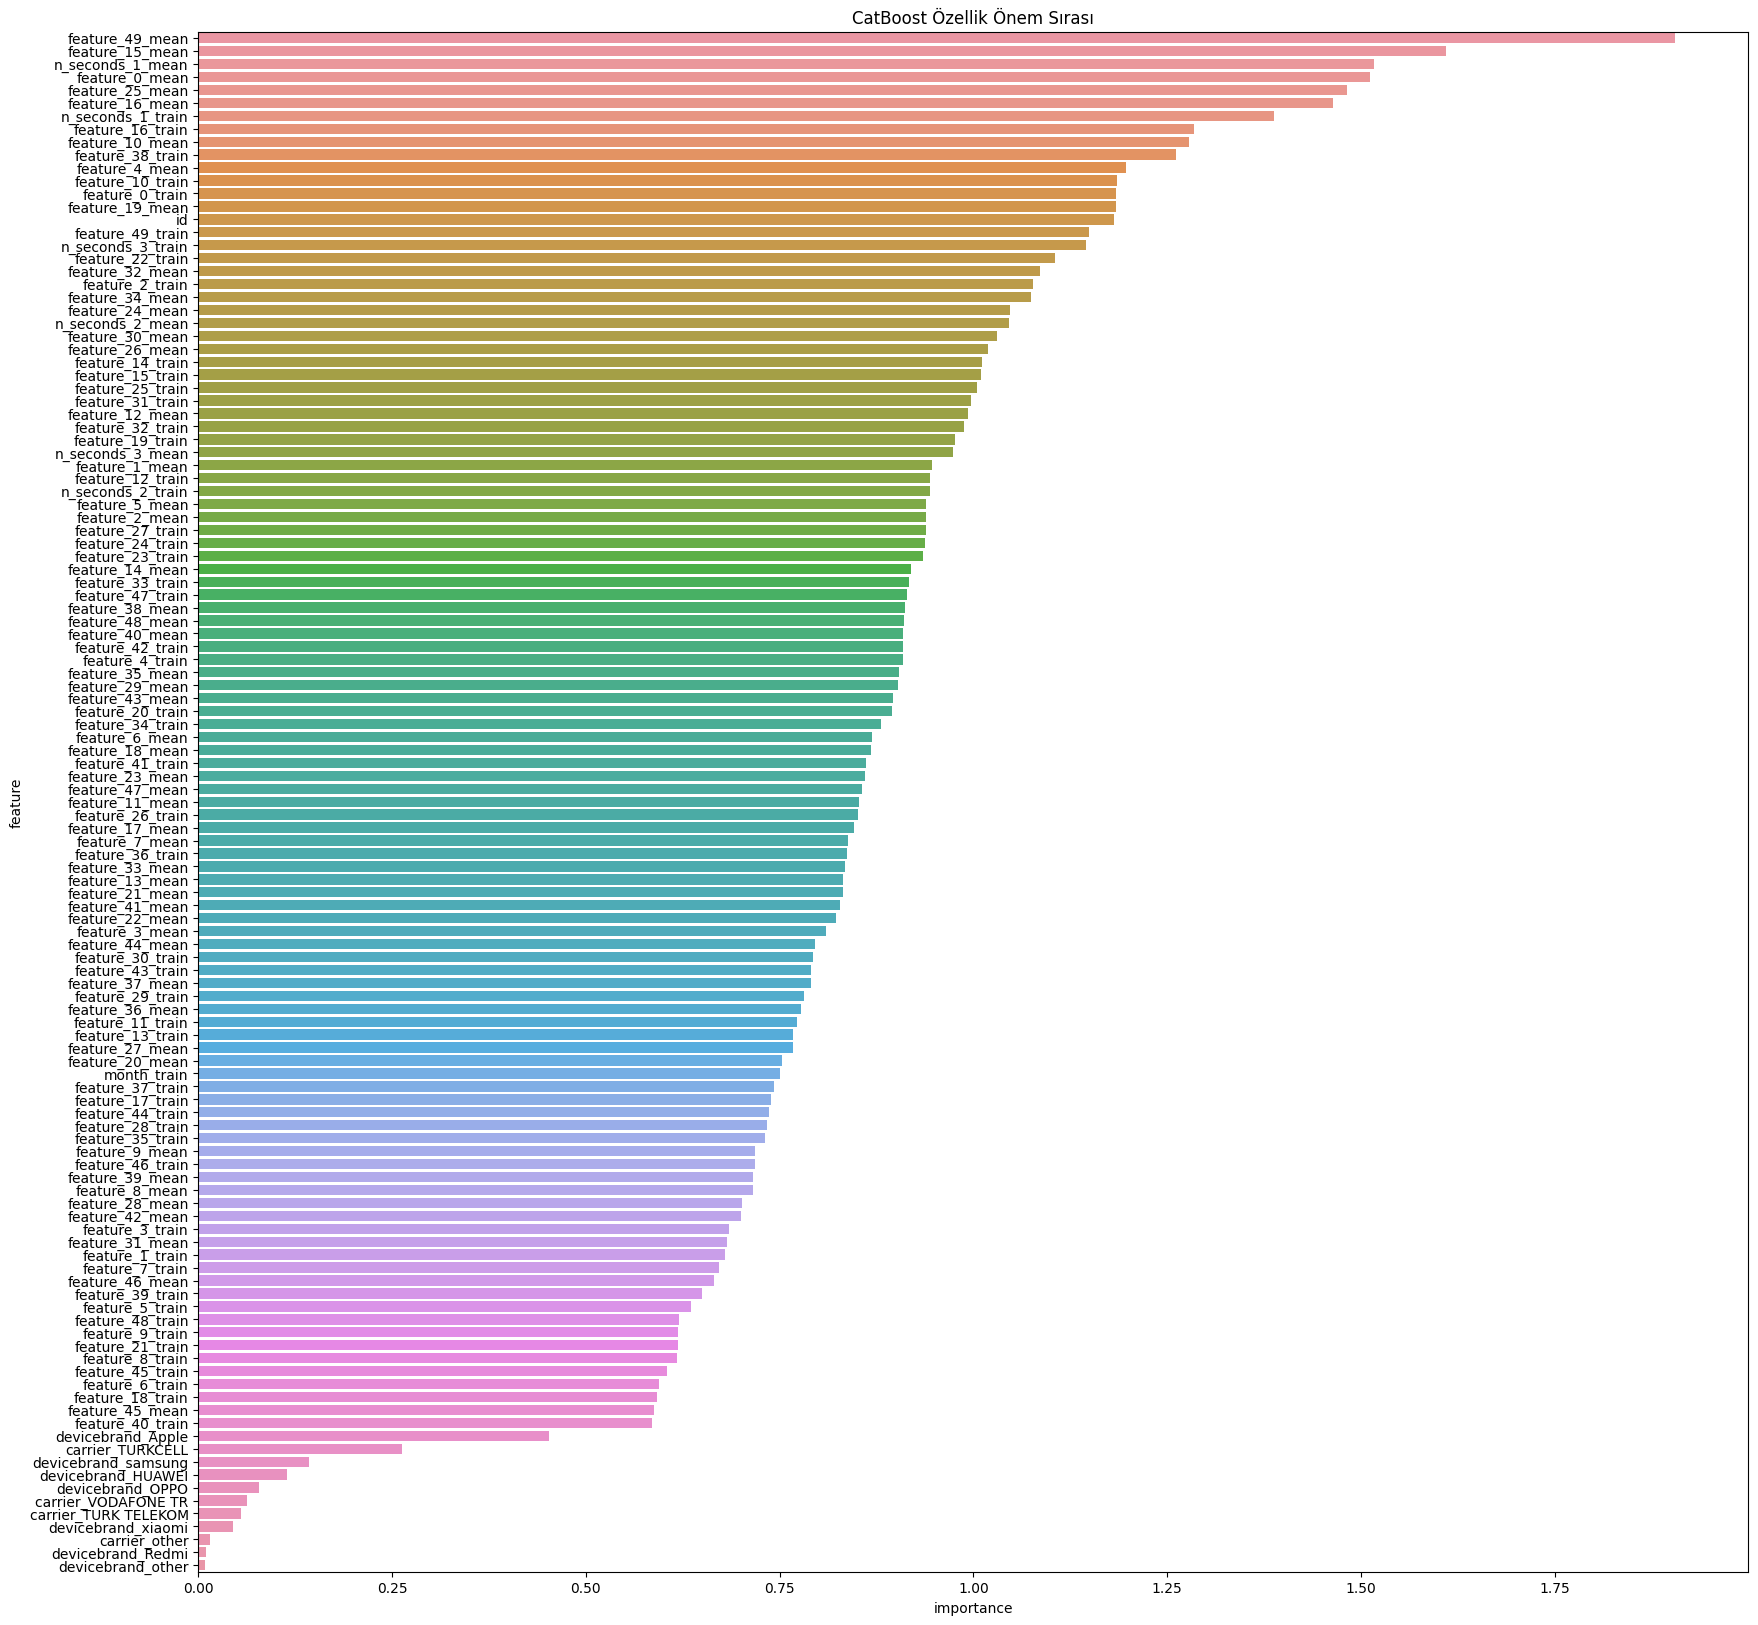

In [20]:
total_importances = ml.estimators_[0].estimators_[2].feature_importances_ 


importances = pd.DataFrame({
    'feature': ml.estimators_[0].estimators_[2].feature_names_ ,
    'importance': total_importances
}).sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 20))
sns.barplot(x='importance', y='feature', data=importances)
plt.title('CatBoost Özellik Önem Sırası')
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'menu1'),
  Text(1, 0, 'menu2'),
  Text(2, 0, 'menu3'),
  Text(3, 0, 'menu4'),
  Text(4, 0, 'menu5'),
  Text(5, 0, 'menu6'),
  Text(6, 0, 'menu7'),
  Text(7, 0, 'menu8'),
  Text(8, 0, 'menu9'),
  Text(9, 0, 'micro avg'),
  Text(10, 0, 'macro avg'),
  Text(11, 0, 'weighted avg'),
  Text(12, 0, 'samples avg')])

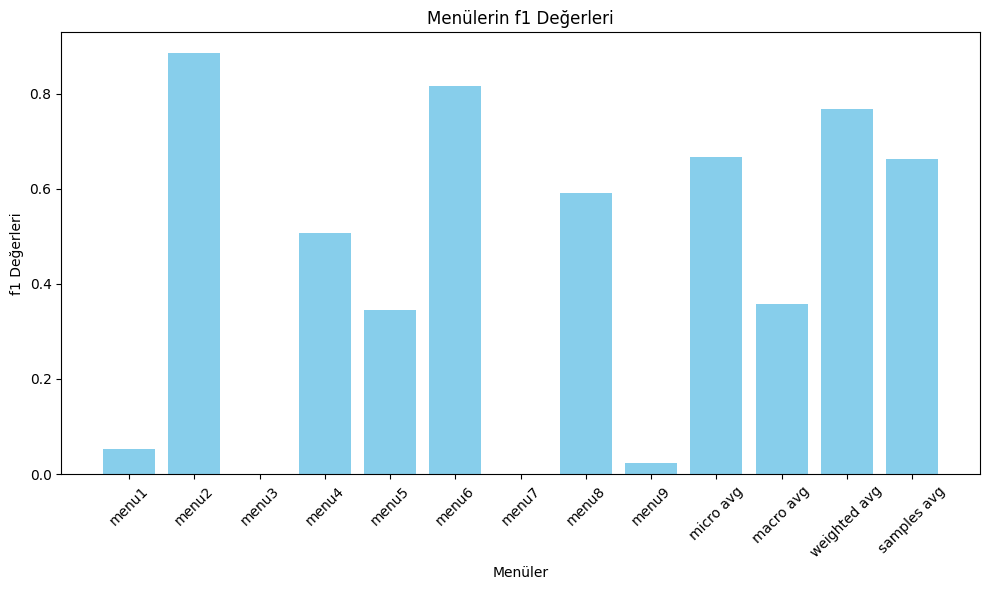

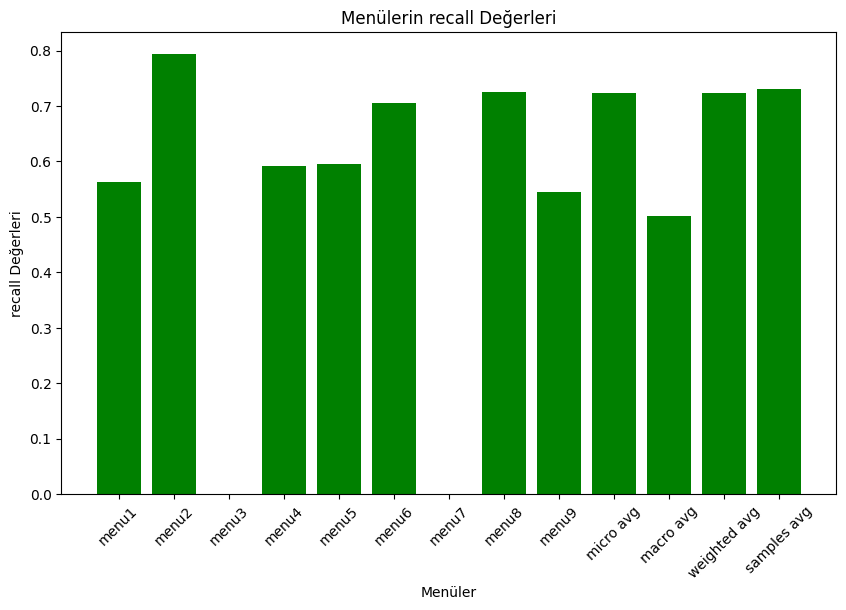

In [21]:
cr =  classification_report(np.vstack(preds),np.vstack(tests),output_dict=True,target_names=['menu1','menu2','menu3','menu4','menu5','menu6','menu7','menu8','menu9'],zero_division=False)


menu_names = list(cr.keys())
precisions = [cr[menu]['f1-score'] for menu in menu_names]

plt.figure(figsize=(10, 6))
plt.bar(menu_names, precisions,color='skyblue')
plt.xlabel('Menüler')
plt.ylabel('f1 Değerleri')
plt.title('Menülerin f1 Değerleri')
plt.xticks(rotation=45)
plt.tight_layout()

menu_names = list(cr.keys())
precisions = [cr[menu]['recall'] for menu in menu_names]

plt.figure(figsize=(10, 6))
plt.bar(menu_names, precisions,color='green')
plt.xlabel('Menüler')
plt.ylabel('recall Değerleri')
plt.title('Menülerin recall Değerleri')
plt.xticks(rotation=45)

## Optuna

In [22]:


""" from sklearn.model_selection import train_test_split

log_params = {
        "C": trial.suggest_float("C", 0.0001, 100, log=True),
        "max_iter": trial.suggest_int("max_iter", 50, 2000),
        'penalty': 'l1',
        'solver': 'liblinear'}

lgb_params = {
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)}


cat_params = {      'depth': trial.suggest_int('depth', 4, 10),
                        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.7, log=True), 
                        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 10),
                        'random_strength': trial.suggest_int('random_strength', 0, 10),
                         'silent': True




X = train[features]
y = train.iloc[:, :9]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

def objective(trial):
    

    
    cat_params = {  'depth': trial.suggest_int('depth', 6, 9),
                        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.07, log=True), 
                        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 6, 8),
                        'random_strength': trial.suggest_int('random_strength', 3, 7),
                         'verbose': 2000   }

    
    
    
    
    
    
    
    ml = MultiOutputClassifier(CatBoostClassifier(**cat_params))
    ml.fit(X_train[features], y_train)
    predicted_ = ml.predict(X_test[features])
    proba = ml.predict_proba(X_test[features])
    
    proba = topprobas(np.array(proba)[:, :, 1].T)
    top3_proba = jaccard_score(proba, y_test, average='micro')
    
    return top3_proba


opt2 = optuna.create_study(direction='maximize')
opt2.optimize(objective, n_trials=200)

# Get the best hyperparameters
best_params = opt2.best_params
best_jaccard_score = opt2.best_value

print("Best Hyperparameters: ", best_params)
print("Best Jaccard Score: ", best_jaccard_score) """

' from sklearn.model_selection import train_test_split\n\nlog_params = {\n        "C": trial.suggest_float("C", 0.0001, 100, log=True),\n        "max_iter": trial.suggest_int("max_iter", 50, 2000),\n        \'penalty\': \'l1\',\n        \'solver\': \'liblinear\'}\n\nlgb_params = {\n        \'max_depth\': trial.suggest_int(\'max_depth\', 1, 15),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.001, 1.0, log=True),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 10, 1000),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 10),\n        \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 1e-8, 1.0, log=True),\n        \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 1e-8, 1.0, log=True)}\n\n\ncat_params = {      \'depth\': trial.suggest_int(\'depth\', 4, 10),\n                        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.001, 0.7, log=True), \n                        \'l2_leaf_reg\': trial.suggest_int(\'l2_l

# submit 

In [23]:
classifier1 = lgb.LGBMClassifier(**lgbbests)
classifier2 = LogisticRegression(**logbests)
classifier3 = CatBoostClassifier(**catbests)

    
voting_classifier = VotingClassifier(estimators=[
                                                 ('lgbm', classifier1),
                                                 ('log', classifier2),
                                                 ('cat', classifier3),
                                                   
                                                 
                                                 
                                               
                                                                         ], voting='soft',verbose=True)

In [24]:
model = MultiOutputClassifier(voting_classifier)
model.fit(train[features], train.iloc[:, :9])

[Voting] ..................... (1 of 3) Processing lgbm, total=   7.2s
[Voting] ...................... (2 of 3) Processing log, total=  21.1s
[Voting] ...................... (3 of 3) Processing cat, total= 1.6min
[Voting] ..................... (1 of 3) Processing lgbm, total=   6.9s
[Voting] ...................... (2 of 3) Processing log, total=  19.5s
[Voting] ...................... (3 of 3) Processing cat, total= 1.6min
[Voting] ..................... (1 of 3) Processing lgbm, total=   6.8s
[Voting] ...................... (2 of 3) Processing log, total=   9.3s
[Voting] ...................... (3 of 3) Processing cat, total= 1.6min
[Voting] ..................... (1 of 3) Processing lgbm, total=   7.7s
[Voting] ...................... (2 of 3) Processing log, total=  21.4s
[Voting] ...................... (3 of 3) Processing cat, total= 1.6min
[Voting] ..................... (1 of 3) Processing lgbm, total=   7.7s
[Voting] ...................... (2 of 3) Processing log, total=  10.7s
[Votin

MultiOutputClassifier(estimator=VotingClassifier(estimators=[('lgbm',
                                                              LGBMClassifier(min_child_samples=298,
                                                                             n_estimators=96,
                                                                             num_leaves=47,
                                                                             reg_alpha=0.0023206893898312765,
                                                                             reg_lambda=0.05066027938622197)),
                                                             ('log',
                                                              LogisticRegression(C=0.1,
                                                                                 intercept_scaling=150,
                                                                                 max_iter=300,
                                                                                 penalty='l1',
                                                                                 solver='liblinear')),
                                                             ('cat',
                                                              <catboost.core.CatBoostClassifier object at 0x7f612896bbe0>)],
                                                 verbose=True, voting='soft'))

In [25]:
voting  = model.predict_proba(test[features])

In [26]:
final_sub  = np.array(voting)[:, :, 1].T
final_sub = topprobas(final_sub).astype(int)
df = pd.DataFrame(final_sub)
df['new_column'] = df.apply(lambda row: ''.join(map(str, row)), axis=1)
submission['target'] = df.new_column


df.groupby(by='new_column').value_counts()

new_column  0  1  2  3  4  5  6  7  8
010101000   0  1  0  1  0  1  0  0  0    8296
010110000   0  1  0  1  1  0  0  0  0    1103
010011000   0  1  0  0  1  1  0  0  0     862
010001001   0  1  0  0  0  1  0  0  1     280
010100001   0  1  0  1  0  0  0  0  1     255
000111000   0  0  0  1  1  1  0  0  0     185
010001010   0  1  0  0  0  1  0  1  0     134
010100010   0  1  0  1  0  0  0  1  0      28
010001100   0  1  0  0  0  1  1  0  0       2
010010001   0  1  0  0  1  0  0  0  1       2
000011001   0  0  0  0  1  1  0  0  1       1
110001000   1  1  0  0  0  1  0  0  0     651
110100000   1  1  0  1  0  0  0  0  0     146
110000001   1  1  0  0  0  0  0  0  1       6
110010000   1  1  0  0  1  0  0  0  0       3
100001001   1  0  0  0  0  1  0  0  1       1
Name: count, dtype: int64

In [27]:
submission.to_csv("submission.csv",index=False)